In [51]:
%matplotlib inline
datadir= './data/'

import urllib.request, os, gzip

def download_data(dataset_name, datadir):
    filename = 'reviews_%s_5.json' % dataset_name
    filepath = os.path.join(datadir, filename)
    if os.path.exists(filepath):
        print("Dataset %s has already been downloaded to %s" % (dataset_name, datadir))
    else:
        url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/%s.gz' % filename
        urllib.request.urlretrieve(url, filepath + ".gz")
        with gzip.open(filepath + ".gz", 'rb') as fin:
            with open(filepath, 'wb') as fout:
                fout.write(fin.read())
        print("Downloaded dataset %s and saved it to %s" % (dataset_name, datadir))
dataset="Apps_for_Android"
download_data(dataset,datadir)

Dataset Apps_for_Android has already been downloaded to ./data/


In [28]:
import json

def load_data(dataset_name, datadir):
    filename = 'reviews_%s_5.json' % dataset_name
    filepath = os.path.join(datadir, filename)
    if not os.path.exists(filepath):
        download_data(dataset_name, datadir)
    data=[]
    with open(filepath,'r') as f: #read file line by line
        for line in f:
            item_hash=hash(line)
            item=json.loads(line)  #convert json to Python dict
            item['hash']=item_hash   #add hash fo indentification purposes
            data.append(item)
    print("Loades %d data for dataset %s" %(len(data), dataset_name))
    return data

#load the data...
apps=load_data(dataset, datadir)
#...and have a look at an example item (item number 9426):
print(apps[9426])
    

Loades 752937 data for dataset Apps_for_Android
{'reviewerID': 'A37ZP4RA4ERTG2', 'asin': 'B004GYYQLA', 'reviewerName': 'Cookie', 'helpful': [7, 8], 'reviewText': "I don't mind ads as much as others so that wasn't a big deal, but it asked for all of this information about you, like your e-mail and zip code, so I deleted it. This ad is not for people who dislike giving out their information.", 'overall': 1.0, 'summary': 'Asks for your info', 'unixReviewTime': 1325289600, 'reviewTime': '12 31, 2011', 'hash': -203795471}


In [29]:
def partition_train_validation_test(data):
    #60% : modulus is 0,1, 2, 3, 4, or 5
    data_train=[item for item in data if item['hash']%10<=5]
    # 20% : modulus is 6, or 7
    data_valid=[item for item in data if item['hash']%10 in [6,7]]
    # 20% : modulus is 8 or 9
    data_test = [item for item in data if item['hash']%10 in [8,9]]
    return data_train, data_valid, data_test

apps_train, apps_valid, apps_test = partition_train_validation_test(apps)
print("Now we have", len(apps_train), "training exemples,", len(apps_valid),
      "validation exemples and", len(apps_test), "test exemples")

Now we have 452176 training exemples, 150355 validation exemples and 150406 test exemples


In [32]:
from nltk.corpus import opinion_lexicon
pos_words = set(opinion_lexicon.positive())
neg_words = set(opinion_lexicon.negative())

import random
random.seed(1234)
print("some positive words:", ",".join(random.sample(pos_words, 10)))
print("some negative words:", ",".join(random.sample(neg_words, 10)))

some positive words: handsomely,precise,lighter,glitz,elatedly,counter-attack,complements,goood,reasonably,simplify
some negative words: last-ditch,profanity,malcontent,despise,fatuously,unhappy,limits,deceiving,cuplrit,notoriety


In [34]:
intersection= pos_words & neg_words
print("Both:", ",".join(intersection))

Both: enviousness,envious,enviously


In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
eng_stopwords = set(stopwords.words('english'))

def my_tokenize(text):
    # split text into lower-case tokens, remowing all punctuation tokens and stopwords
    tokens=[]
    for sentence in sent_tokenize(text):
        tokens.extend( x for x in word_tokenize(sentence.lower())
                     if x not in eng_stopwords and any(i.isalpha() for i in x))
    return tokens
        
def pos_neg_fraction(text):
    tokens=my_tokenize(text)
    count_pos, count_neg=0,0
    for t in tokens:
        if t in pos_words:
            count_pos+=1
        if t in neg_words:
            count_neg+=1
    count_all=len(tokens)
    if count_all==0:
        return 0.0,0.
    return count_pos/count_all, count_neg/count_all

pos_example = 'This is a good, great, fantastic, amazing, wonderful, super product!!!'
neg_example = 'This is a bad, atrocious, terrible, dreadful, awful, abysmal product!!!'
print(pos_neg_fraction(pos_example))
print(pos_neg_fraction(neg_example))

(0.8571428571428571, 0.0)
(0.0, 0.8571428571428571)


In [9]:
import numpy

def dataset_to_matrix(data):
    return numpy.array([list(pos_neg_fraction(item['reviewText'])) for item in data])

X_train = dataset_to_matrix(apps_train)
most_pos, most_neg = numpy.argmax(X_train, axis=0)
# print the example with the highest fraction of positive words:
print("We found a fraction of %f %% positive words for example %d" % 
      (100.*X_train[most_pos, 0], most_pos))
print(apps_train[most_pos])
print("We found a fraction of %f %% negative words for example %d" %
      (100.*X_train[most_neg, 1], most_neg))
print(apps_train[most_neg])

We found a fraction of 100.000000 % positive words for example 832
{'reviewerID': 'AWUDE6LOH5Y2Q', 'asin': 'B004DLPXAO', 'reviewerName': 'Amazon Customer', 'helpful': [0, 0], 'reviewText': 'Love it!', 'overall': 5.0, 'summary': 'Take you Kindle Library along whenever you have your phone!', 'unixReviewTime': 1404691200, 'reviewTime': '07 7, 2014', 'hash': 1736703145}
We found a fraction of 100.000000 % negative words for example 6427
{'reviewerID': 'A1HZYCWWJ53TS5', 'asin': 'B004HE5TAG', 'helpful': [0, 0], 'reviewText': 'boring', 'overall': 2.0, 'summary': 'Two Stars', 'unixReviewTime': 1405382400, 'reviewTime': '07 15, 2014', 'hash': -1234218198}


In [10]:
def dataset_to_targets(data):
    return numpy.array([item['overall'] for item in data])

Y_train = dataset_to_targets(apps_train)
print("Our feature matrix is two-dimensional and has shape", X_train.shape)
print("Our target vector is one-dimensional and has shape", Y_train.shape)

Our feature matrix is two-dimensional and has shape (452176, 2)
Our target vector is one-dimensional and has shape (452176,)


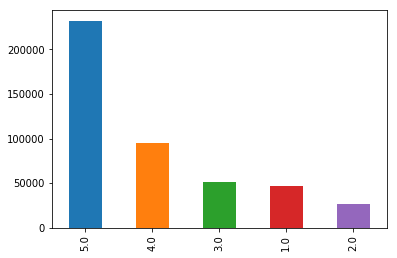

In [11]:
import pandas
pandas.Series(Y_train).value_counts().plot.bar()

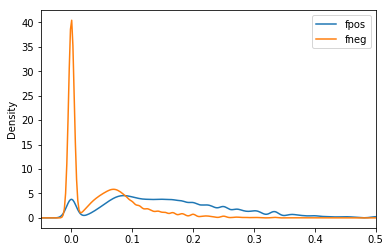

In [12]:
df = pandas.DataFrame(data=X_train, columns = ['fpos', 'fneg'])
df.plot.kde(xlim=(-0.05, 0.5))

In [13]:
from  sklearn.linear_model import LinearRegression
lreg = LinearRegression().fit(X_train, Y_train)

print("The coefficient for the fpos variable is", lreg.coef_[0])
print("The coefficient for the fneg variable is", lreg.coef_[1])
print("The intercept is", lreg.intercept_)

The coefficient for the fpos variable is 3.770666933284577
The coefficient for the fneg variable is -3.9491410649835212
The intercept is 3.546301581988246


In [14]:
features = [[0.2, 0]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 0.2*lreg.coef_[0] + 0*lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is 4.300435 stars
This is the same as 4.300435 stars


In [15]:
features = [[0, 0.2]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 0 * lreg.coef_[0] + 0.2 * lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is 2.756473 stars
This is the same as 2.756473 stars


In [38]:
features = [[1, 0]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 1 * lreg.coef_[0] + 0 * lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is 7.316969 stars
This is the same as 7.316969 stars


In [39]:
features = [[0, 1]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 0 * lreg.coef_[0] + 1 * lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is -0.402839 stars
This is the same as -0.402839 stars


In [18]:

def  predict_lreg (features):
    expected_rating = lreg.predict(features)
    expected_rating[expected_rating > 5.0] = 5.0
    expected_rating[expected_rating < 1.0] = 1.0
    return expected_rating

pred_train = predict_lreg(X_train)

In [35]:
features = [[1, 0]]
expected_rating_A = predict_lreg(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 1 * lreg.coef_[0] + 0 * lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is 5.000000 stars
This is the same as 7.316969 stars


In [37]:
features = [[0, 1]]
expected_rating_A = predict_lreg(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 0 * lreg.coef_[0] + 1 * lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is 1.000000 stars
This is the same as -0.402839 stars


In [22]:
def analyze_training_example(i):
    print("Training example number", i)
    print("True rating = %f stars, expected rating = %f stars" % (Y_train[i], 
                                                                  pred_train[i]))
    print("Features = %f / %f" % (X_train[i,0], X_train[i,1]))
    print("Review text = %s" % apps_train[i]['reviewText'])

for i in [0, 10000, 20000, 30000, 50000]:
    analyze_training_example(i)

Training example number 0
True rating = 3.000000 stars, expected rating = 4.231877 stars
Features = 0.181818 / 0.000000
Review text = Loves the song, so he really couldn't wait to play this. A little less interesting for him so he doesn't play long, but he is almost 3 and likes to play the older games, but really cute for a younger child.
Training example number 10000
True rating = 1.000000 stars, expected rating = 3.860524 stars
Features = 0.083333 / 0.000000
Review text = I was really hoping that the game is going to work and I was looking forward to playing the game but it won't start
Training example number 20000
True rating = 2.000000 stars, expected rating = 3.523992 stars
Features = 0.125000 / 0.125000
Review text = This app wasn't overly helpful to me on any of my electronics. All it really did was drain my battery.
Training example number 30000
True rating = 4.000000 stars, expected rating = 4.433517 stars
Features = 0.235294 / 0.000000
Review text = I mean for a free app this

In [24]:
from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(pred_train, Y_train)
print("The mean absolute error on the training data is %f stars" % mae_train)

The mean absolute error on the training data is 0.992722 stars


In [25]:
def discretize_targets(Y):
    return Y<=3.0

D_train = discretize_targets(Y_train)
print("The training data contains %f %% dissatisfied customers" % (100.*D_train.mean()))
print(D_train[:10])

The training data contains 27.720843 % dissatisfied customers
[ True False False False False False  True False False False]


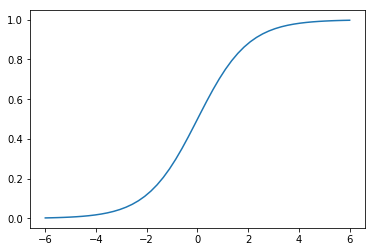

In [26]:
points = numpy.linspace(-6.0, 6.0)
logistic_function = pandas.Series(1/(numpy.exp(-points)+1), index=points)
logistic_function.plot()

In [55]:
from  sklearn.linear_model  import LogisticRegression
logreg = LogisticRegression().fit(X_train, D_train)
# The predict_proba() method produces a matrix with two columns
# the first column contains the probability for the label being "false" (satisfied customer)
# the second column contains the probability for the label being "true" (dissatisfied customer)
# the sum of both columns is 1
# we select the second column with [:,1]
# [:,0] would select the first column
# [1,:] would select the second row
prob2_train = logreg.predict_proba(X_train)[:,1]
pred2_train = prob2_train > 0.5
max_prob2 = numpy.argmax(prob2_train)
min_prob2 = numpy.argmin(prob2_train)

def analyze_training_example_2(i):
    print("Training example number", i)
    print("True rating = %f stars" % Y_train[i])
    print("Expected to be dissatisfied:", pred2_train[i])
    print("Expected probability of being dissatisfied : %f" % prob2_train[i])
    print("Features = %f / %f" % (X_train[i,0], X_train[i,1]))
    print("Review text = %s" % apps_train[i]['reviewText'])
    
analyze_training_example_2(max_prob2)

Training example number 6427
True rating = 2.000000 stars
Expected to be dissatisfied: True
Expected probability of being dissatisfied : 0.996452
Features = 0.000000 / 1.000000
Review text = boring


In [47]:
analyze_training_example_2(min_prob2)

Training example number 832
True rating = 5.000000 stars
Expected to be dissatisfied: False
Expected probability of being dissatisfied : 0.000192
Features = 1.000000 / 0.000000
Review text = Love it!


In [56]:
from  sklearn.metrics  import precision_score, recall_score
precision2 = precision_score(D_train, pred2_train)
recall2 = recall_score(D_train, pred2_train)
print("For the default threshold (0.5) we get precision = %f "
      "and recall = %f" % (precision2, recall2))

For the default threshold (0.5) we get precision = 0.650743 and recall = 0.227353


In [49]:
from  sklearn.linear_model  import LogisticRegression
logreg = LogisticRegression().fit(X_train, D_train)
# The predict_proba() method produces a matrix with two columns
# the first column contains the probability for the label being "false" (satisfied customer)
# the second column contains the probability for the label being "true" (dissatisfied customer)
# the sum of both columns is 1
# we select the second column with [:,1]
# [:,0] would select the first column
# [1,:] would select the second row
prob2_train = logreg.predict_proba(X_train)[:,1]
pred2_train = prob2_train > 0.2
max_prob2 = numpy.argmax(prob2_train)
min_prob2 = numpy.argmin(prob2_train)

def analyze_training_example_2(i):
    print("Training example number", i)
    print("True rating = %f stars" % Y_train[i])
    print("Expected to be dissatisfied:", pred2_train[i])
    print("Expected probability of being dissatisfied : %f" % prob2_train[i])
    print("Features = %f / %f" % (X_train[i,0], X_train[i,1]))
    print("Review text = %s" % apps_train[i]['reviewText'])
    
analyze_training_example_2(max_prob2)

Training example number 6427
True rating = 2.000000 stars
Expected to be dissatisfied: True
Expected probability of being dissatisfied : 0.996452
Features = 0.000000 / 1.000000
Review text = boring


In [50]:
analyze_training_example_2(min_prob2)

Training example number 832
True rating = 5.000000 stars
Expected to be dissatisfied: False
Expected probability of being dissatisfied : 0.000192
Features = 1.000000 / 0.000000
Review text = Love it!


In [54]:
from  sklearn.metrics  import precision_score, recall_score
precision2 = precision_score(D_train, pred2_train)
recall2 = recall_score(D_train, pred2_train)
print("For the default threshold (0.2) we get precision = %f "
      "and recall = %f" % (precision2, recall2))

For the default threshold (0.2) we get precision = 0.371653 and recall = 0.842485
